In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

import os
import helper as hp
from configparser import ConfigParser

from kinetics.jacobian_solver import check_jacobian
from ppo_refinement import PPORefinement

# Train PPO agent

In [2]:
#Parse arguments from configfile
configs = ConfigParser()
configs.read('configfile.ini')

n_samples = int(configs['MLP']['n_samples']) # Used by MLP for its internal sampling if any, and for p0 generation.

lnminkm = float(configs['CONSTRAINTS']['min_km'])
lnmaxkm = float(configs['CONSTRAINTS']['max_km'])

repeats = int(configs['EVOSTRAT']['repeats'])
generations = int(configs['EVOSTRAT']['generations']) # Will be used as num_iterations for PPO
ss_idx = int(configs['EVOSTRAT']['ss_idx'])
# n_threads = int(configs['EVOSTRAT']['n_threads']) # PPO collection is currently single-threaded

output_path = configs['PATHS']['output_path']
met_model = configs['PATHS']['met_model']
names_km_config = hp.load_pkl(f'models/{met_model}/parameter_names_km_fdp1.pkl') # Full list of param names

# Parameters needed directly by PPORefinement
param_dim_config = int(configs['MLP']['no_kms'])
latent_dim_config = int(configs['MLP']['latent_dim']) # For z vector in state


# Call solvers from SKimPy (Used only for initial messages now)
chk_jcbn = check_jacobian()

In [3]:
# Integrate data
print('---- Load kinetic and thermodynamic data')
chk_jcbn._load_ktmodels(met_model, 'fdp1')           ## Load kinetic and thermodynamic data
print('---- Load steady state data')
chk_jcbn._load_ssprofile(met_model, 'fdp1', ss_idx)  ## Integrate steady state information

---- Load kinetic and thermodynamic data


2025-05-14 14:24:20,353 - thermomodel_new - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2025-05-14 14:24:21,832 - Unnamed - WARNING - Non integer stoichiometries found ['CYTBO3_4pp', 'LMPD_biomass_c_1_420', 'CYTBDpp'] change to integer for linear dependencies
2025-05-14 14:24:22,167 - Unnamed - WARNING - Non integer stoichiometries found ['CYTBO3_4pp', 'LMPD_biomass_c_1_420', 'CYTBDpp'] change to integer for linear dependencies


---- Load steady state data


In [4]:
lambda_partition = -2.5
reward_flag = 0

def _get_lambda_max(p_tensor_single):
    p_numpy = p_tensor_single.detach().cpu().numpy()
    # Use the stored chk_jcbn instance
    chk_jcbn._prepare_parameters([p_numpy], names_km_config) 
    max_eig_list = chk_jcbn.calc_eigenvalues_recal_vmax()
    max_eig_list.sort()

    return max_eig_list

def compute_reward(p_tensor_single, n_consider=10):
    lambdas_val = _get_lambda_max(p_tensor_single)

    if reward_flag == 0:
        lambda_max_val = lambdas_val[0]
        penalty = np.maximum(0, lambda_max_val)
        if lambda_max_val > 100:
            lambda_max_val = 100
        r = 1.0 / (1.0 + np.exp(lambda_max_val - lambda_partition))
        r -= penalty
    else:
        considered_avg = sum(lambdas_val[:n_consider]) / n_consider
        r = np.exp(-0.1 * considered_avg) / 2
    # TODO: Right now, we are not using the Incidence part of the reward.

    return r


In [5]:
print('--- Begin PPO refinement strategy')

this_savepath = f'{output_path}/ppo/' 
os.makedirs(this_savepath, exist_ok=True)

ppo_agent = PPORefinement(
    param_dim=param_dim_config,
    noise_dim=latent_dim_config,
    reward_function=compute_reward,
    min_x_bounds=lnminkm,
    max_x_bounds=lnmaxkm,
    ppo_epochs=10,
    T_horizon=100,
    actor_lr=1e-5,
    critic_lr=5e-5,
)

trained_actor, rewards = ppo_agent.train(num_training_iterations=100, output_path=this_savepath)

print(f"PPO training finished. Rewards log saved to {this_savepath}")


--- Begin PPO refinement strategy
Training on cpu
Iteration 1/100, Final Reward: -0.9760
Iteration 2/100, Final Reward: -22.7623
Iteration 3/100, Final Reward: 0.1104
Iteration 4/100, Final Reward: 0.0796
Iteration 5/100, Final Reward: -173.5119
Iteration 6/100, Final Reward: -59.5943
Iteration 7/100, Final Reward: 0.0929
Iteration 8/100, Final Reward: -30.9958
Iteration 9/100, Final Reward: -176.4228
Iteration 10/100, Final Reward: 0.0348
Iteration 11/100, Final Reward: 0.0683
Iteration 12/100, Final Reward: -5.7039
Iteration 13/100, Final Reward: -149.0122
Iteration 14/100, Final Reward: -26.4227
Iteration 15/100, Final Reward: 0.0915
Iteration 16/100, Final Reward: 0.2198
Iteration 17/100, Final Reward: 0.0818
Iteration 18/100, Final Reward: 0.1007
Iteration 19/100, Final Reward: -100.9788
Iteration 20/100, Final Reward: 0.0868
Iteration 21/100, Final Reward: 0.0807
Iteration 22/100, Final Reward: 0.1405
Iteration 23/100, Final Reward: -46.8906
Iteration 24/100, Final Reward: 0.2062

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-5jde8esd because the default path (/home/renaissance/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Text(0.5, 1.0, 'PPO Training Rewards')

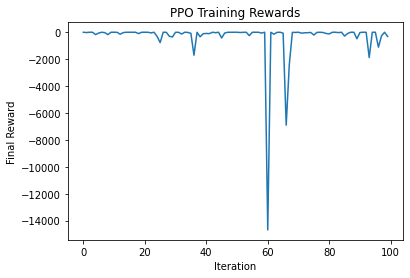

In [6]:
from matplotlib import pyplot as plt
plt.plot(rewards)
plt.xlabel('Iteration')
plt.ylabel('Final Reward')
plt.title('PPO Training Rewards')

In [7]:
def evaluate_policy_incidence(trained_actor, ppo_agent, num_trials=50):
    T_HORIZON = ppo_agent.T_horizon
    NOISE_DIM = ppo_agent.noise_dim
    N_TRIALS = num_trials
    incidence = 0
    for _ in range(N_TRIALS):
        current_params_in_state = ppo_agent._initialize_current_params_for_state().clone()
        generated_sequence = []
        for _ in range(T_HORIZON):
            noise = torch.randn(NOISE_DIM, device=ppo_agent.device)
            state_1d = torch.cat((noise, current_params_in_state.detach()), dim=0)
            state_batch = state_1d.unsqueeze(0)
            with torch.no_grad():
                mu_raw, log_std_raw = trained_actor(state_batch)
                # For generation, you might want to take the mean (mu_raw) or sample
                # action_raw = mu_raw # Deterministic generation
                action_raw = Normal(mu_raw, torch.exp(log_std_raw)).sample() # Stochastic generation
            
            ode_params = ppo_agent._transform_to_bounded(action_raw)
            current_params_in_state = ode_params.squeeze(0)
            generated_sequence.append(current_params_in_state.cpu().numpy())

        final_generated_params = generated_sequence[-1]
        final_reward_eval = compute_reward(torch.tensor(final_generated_params, device=ppo_agent.device))
        lambda_max = _get_lambda_max(torch.tensor(final_generated_params, device=ppo_agent.device))[0]
        if lambda_max < -2.5:
            incidence += 1
        print(f"Final lambda_max: {lambda_max:.4f}")
        print(f"Final reward: {final_reward_eval:.4f}")
    print(f"Incidence over {N_TRIALS} trials: {incidence}/{N_TRIALS} = {incidence/N_TRIALS:.2f}")


In [8]:
evaluate_policy_incidence(trained_actor, ppo_agent, num_trials=50)

Final lambda_max: 69.4703
Final reward: -69.4703
Final lambda_max: 73.0140
Final reward: -73.0140
Final lambda_max: 72.2073
Final reward: -72.2073
Final lambda_max: 69.2726
Final reward: -69.2726
Final lambda_max: 69.0081
Final reward: -69.0081
Final lambda_max: 69.3999
Final reward: -69.3999
Final lambda_max: 73.5059
Final reward: -73.5059
Final lambda_max: 74.9172
Final reward: -74.9172
Final lambda_max: 67.6325
Final reward: -67.6325
Final lambda_max: 66.7483
Final reward: -66.7483
Final lambda_max: 69.9099
Final reward: -69.9099
Final lambda_max: 66.9351
Final reward: -66.9351
Final lambda_max: 69.5804
Final reward: -69.5804
Final lambda_max: 68.9582
Final reward: -68.9582
Final lambda_max: 69.6110
Final reward: -69.6110
Final lambda_max: 70.0161
Final reward: -70.0161
Final lambda_max: 68.8618
Final reward: -68.8618
Final lambda_max: 67.1279
Final reward: -67.1279
Final lambda_max: 71.2430
Final reward: -71.2430
Final lambda_max: 70.7899
Final reward: -70.7899
Final lambda_max: 69

## Test on simple ODE

In [9]:
def _get_lambda_max(p_tensor_single):
    # Convert tensor to NumPy array
    p_numpy = p_tensor_single.detach().cpu().numpy()
    
    # Determine size of system
    param_len = p_numpy.shape[0]
    n = int(np.sqrt(param_len))
    assert n * n == param_len, f"Parameter size must be a perfect square (got {param_len})"
    
    # Reshape into square matrix A
    A = p_numpy.reshape((n, n))
    
    # In linear system dx/dt = A x, Jacobian is just A
    jacobian = A

    # Compute eigenvalues
    eigvals = np.linalg.eigvals(jacobian)

    # Sort eigenvalues by real part descending
    eigvals_sorted = sorted(eigvals, key=lambda x: x.real, reverse=True)

    return eigvals_sorted

def compute_reward(p_tensor_single, n_consider=10):
    lambdas_val = _get_lambda_max(p_tensor_single)

    if reward_flag == 0:
        lambda_max_val = lambdas_val[0]
        penalty = np.maximum(0, lambda_max_val)
        if lambda_max_val > 100:
            lambda_max_val = 100
        r = 1.0 / (1.0 + np.exp(lambda_max_val - lambda_partition))
        r -= penalty
    else:
        considered_avg = sum(lambdas_val[:n_consider]) / n_consider
        r = np.exp(-0.1 * considered_avg) / 2
    # TODO: Right now, we are not using the Incidence part of the reward.

    return r

In [10]:
print('--- Begin PPO refinement strategy')

this_savepath = f'{output_path}/ppo/' 
os.makedirs(this_savepath, exist_ok=True)

ppo_agent = PPORefinement(
    param_dim=4,
    noise_dim=10,
    reward_function=compute_reward,
    min_x_bounds=lnminkm,
    max_x_bounds=lnmaxkm,
    ppo_epochs=10,
    T_horizon=100,
    actor_lr=1e-5,
    critic_lr=5e-5,
)

trained_actor, rewards = ppo_agent.train(num_training_iterations=100, output_path=this_savepath)

print(f"PPO training finished. Rewards log saved to {this_savepath}")


--- Begin PPO refinement strategy
Training on cpu
Iteration 1/100, Final Reward: 0.9998
Iteration 2/100, Final Reward: -8.2187
Iteration 3/100, Final Reward: -7.1311
Iteration 4/100, Final Reward: 0.0614
Iteration 5/100, Final Reward: 1.0000
Iteration 6/100, Final Reward: -7.0519
Iteration 7/100, Final Reward: -4.6441
Iteration 8/100, Final Reward: 0.2225
Iteration 9/100, Final Reward: -14.1857
Iteration 10/100, Final Reward: -10.2685
Iteration 11/100, Final Reward: 1.0000
Iteration 12/100, Final Reward: 0.1518
Iteration 13/100, Final Reward: 0.9880
Iteration 14/100, Final Reward: -15.0717
Iteration 15/100, Final Reward: 1.0000-0.0000j


/home/renaissance/work/ppo_refinement.py:134 ComplexWarning: Casting complex values to real discards the imaginary part


Iteration 16/100, Final Reward: -9.7747
Iteration 17/100, Final Reward: 1.0000
Iteration 18/100, Final Reward: -7.5858
Iteration 19/100, Final Reward: -8.6957
Iteration 20/100, Final Reward: 0.5109
Iteration 21/100, Final Reward: 1.0000
Iteration 22/100, Final Reward: -7.8781
Iteration 23/100, Final Reward: 1.0000
Iteration 24/100, Final Reward: -14.7458
Iteration 25/100, Final Reward: -11.4886
Iteration 26/100, Final Reward: 1.0000
Iteration 27/100, Final Reward: 0.3712
Iteration 28/100, Final Reward: 0.9118
Iteration 29/100, Final Reward: 0.1378
Iteration 30/100, Final Reward: 1.0000
Iteration 31/100, Final Reward: -2.4981
Iteration 32/100, Final Reward: 0.2180
Iteration 33/100, Final Reward: -5.8684
Iteration 34/100, Final Reward: 0.9927
Iteration 35/100, Final Reward: -8.4762
Iteration 36/100, Final Reward: 0.3667
Iteration 37/100, Final Reward: 0.4315
Iteration 38/100, Final Reward: -1.7099
Iteration 39/100, Final Reward: -8.5449
Iteration 40/100, Final Reward: -3.2511
Iteration 4